In [123]:
using Korg, PyPlot, Trapz, Random. ForwardDiff

In [4]:
lines = Korg.get_GES_linelist();

┌ Warning: This function is may fail on some systems. See https://github.com/ajwheeler/Korg.jl/issues/309 for details.
└ @ Korg ~/.julia/packages/Korg/YXHXN/src/linelist.jl:635


This note boook is to test the behavior expected for $\partial Flux / \partial \log A$ at the linear part of the absorption line.  
In the linear part,  
$\log EW = \log A + const. $,  
therefore  
$\frac{\partial EW}{\partial \log A} = \ln(10) EW$.
Since $depth \propto EW $, the same relation holds for the depth:  
$\frac{\partial depth}{\partial \log A} = \ln(10) depth$.  
From the Cayrel formula, we can estimate the depth at the detection limit, and if we believe the above calculation, we can then estimate $\frac{\partial depth}{\partial \log A}$ at the detection limit, which might be useful for determining the detection limit in machine-learning based method, such as Payne.


In [99]:
lines = Korg.get_VALD_solar_linelist();

In [100]:
for _line in enumerate(lines)
    ii,line = _line
    if string(line.species) == "Sr II"
        print(ii," ",line.wl*1.0e8)
        print("\n")
    end
end

10003 3381.6778
11960 3465.4454
12179 3475.884
24579 4078.8607
25916 4162.9651
26970 4216.7067
28392 4306.6545


In [101]:
line = lines[24579:24579]

1-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Sr II 4078.8607 Å (log gf = 0.14, χ = 0.0 eV)

In [248]:
feh = -2.
alpha_h = -1.6
A_X_model = format_A_X(feh,alpha_h);
atm = interpolate_marcs(5000,2.0,A_X);
resolution = 20000
dwvl = 4077/resolution/4
obs_wl = 4060:dwvl:4100;
syn_wl = 4050:0.01:4110;
LSF = Korg.compute_LSF_matrix(syn_wl,obs_wl,resolution);
idx_center= findmin(abs,obs_wl.-4078.8607)[2];


In [321]:
alpha = 1.52
snr_per_ang = 50
nsig_detect = 3
err_ew = alpha * sqrt(4077/resolution) / snr_per_ang * 1.0e3
ew_detect_lim = err_ew*3
. = snr_per_ang * sqrt(dwvl)
depth_limit = nsig_detect / ( sqrt(2*pi) / (alpha*2*sqrt(2*log(2))) * snr_per_ang * sqrt(4077/resolution))
del_dep_logA_lim = nsig_detect / ( sqrt(2*pi) / (alpha*2*sqrt(2*log(2))*log(10.)) * snr_per_ang * sqrt(4077/resolution))

0.4369411616647108

In [279]:
depth_limit

0.18976113542738055

11.287437707469309

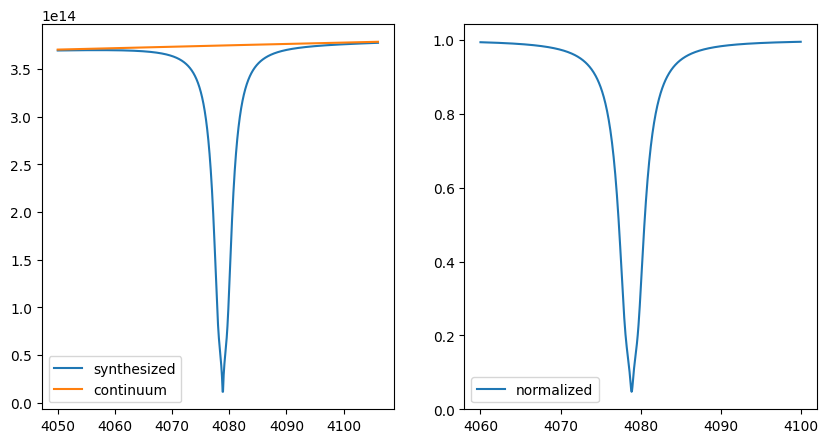

In [166]:
fig,axs = subplots(1,2,figsize=(10,5))
sca(axs[1])
plot(sol.wavelengths, sol.flux, "C0-",label="synthesized")
plot(sol.wavelengths, sol.cntm, "C1-",label="continuum")
legend()
sca(axs[2])
noise = 1.0e-2 .* randn(length(obs_wl))
plot(obs_wl, LSF * (sol.flux ./ sol.cntm), "C0-",label="normalized")
#plot(obs_wl, LSF * (sol.flux ./ sol.cntm) .+ noise, "ko",label="noise added",ms=3.)
legend();

In [182]:
function get_spectrum_Sr(sr_h, LSF = LSF, atm=atm, line = line, 
        feh = feh, alpha_h = alpha_h)
    A_X = format_A_X(feh,alpha_h,Dict("Sr"=>sr_h))
    sol = synthesize(atm, line, A_X, syn_wl, 
        hydrogen_lines=false);
    LSF * (sol.flux ./ sol.cntm)
end

get_spectrum_Sr (generic function with 8 methods)

In [202]:
function get_ew(spec)
    trapz(obs_wl,1.0.-spec)*1.0e3
end

get_ew (generic function with 1 method)

In [183]:
_get_spectrum_one = (p) -> get_spectrum_Sr(p)

#3 (generic function with 1 method)

In [208]:
function get_diff_spectrum(p)
    ForwardDiff.derivative(_get_spectrum_one,p)
end

get_diff_spectrum (generic function with 1 method)

In [288]:
srewbin = -6:0.1:1
spectra = get_spectrum_Sr.(srewbin)
diff_spec = get_diff_spectrum.(srewbin);

In [308]:

ew = get_ew.(spectra)
depth = 1.0 .- minimum.(spectra)
max_diff = maximum.(abs,diff_spec);
center_diff = map(s -> s[idx_center],diff_spec);
dewdlogA = map(diff_s -> trapz(obs_wl,diff_s)*1.0e3,diff_spec);
dlogewdlogA = -dewdlogA ./ ew / log(10.);

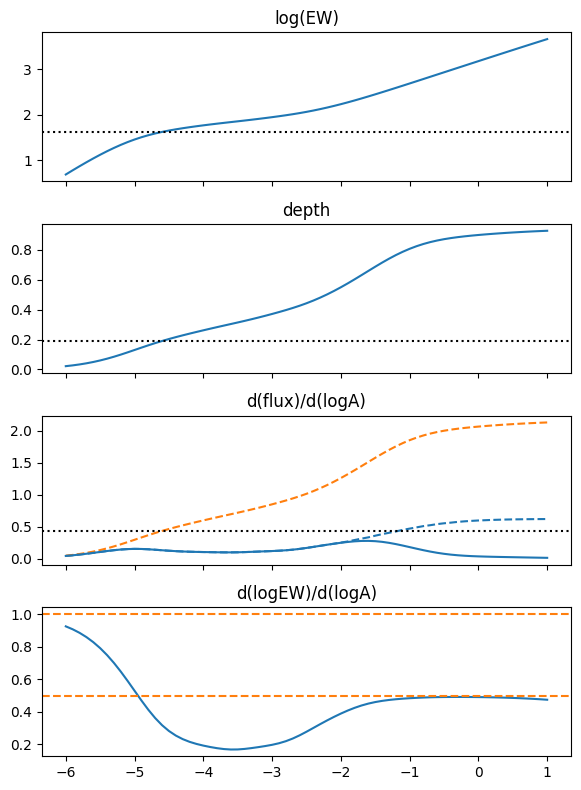

In [322]:
fig,axs = subplots(4,1,figsize=(6,8),sharex=true)
sca(axs[1])
title("log(EW)")
plot(srewbin,log10.(ew))
axhline(log10(err_ew*3),color="k",ls=":")
sca(axs[2])
title("depth")
plot(srewbin,depth)
axhline(depth_limit,color="k",ls=":")
sca(axs[3])
title("d(flux)/d(logA)")
plot(srewbin,max_diff,"C0--",label="maximum")
plot(srewbin,depth*log(10),"C1--",label="expected at center")
plot(srewbin,.- center_diff,"C0-",label="center")
axhline(del_dep_logA_lim,color="k",ls=":")
sca(axs[4])
title("d(logEW)/d(logA)")
plot(srewbin,dlogewdlogA,"C0-")
axhline(1.0,color="C1",ls="--",label="linear part")
axhline(0.5,color="C1",ls="--",label="linear part")

tight_layout()

This result seems to suggest that $\frac{\partial flux}{\partial \log A}$ does not behave as we expected. Already at the detection limit, the absorption line deviates from the linear part.

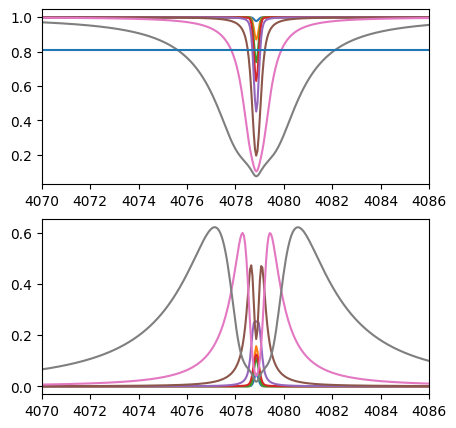

(4070.0, 4086.0)

In [318]:
fig,axs = subplots(2,1,figsize=(5,5))
sca(axs[1])
for spec in spectra[begin:10:end]
    plot(obs_wl,spec)
end
axhline(1.0-depth_limit)
xlim(4070,4086)
sca(axs[2])
for diff_s in diff_spec[begin:10:end]
    plot(obs_wl,.-diff_s)     
end
xlim(4070,4086)

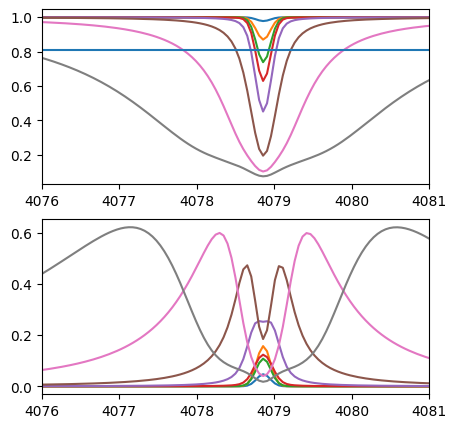

(4076.0, 4081.0)

In [319]:
fig,axs = subplots(2,1,figsize=(5,5))
sca(axs[1])
for spec in spectra[begin:10:end]
    plot(obs_wl,spec)
end
axhline(1.0-depth_limit)
xlim(4076,4081)
sca(axs[2])
for diff_s in diff_spec[begin:10:end]
    plot(obs_wl,.-diff_s)     
end
xlim(4076,4081)